In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

# Set root
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')

from modeling.Inception import *


def plot_roc_auc(y_pred, y_true):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.title('ROC curve')
    plt.show()

def plot_prc(y_pred,y_true):
    from sklearn.metrics import precision_recall_curve, auc
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label='ROC curve (area = %0.2f)' % auc_pr)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.title("Precision-Recall Curve")
    plt.show()

def _get_sample(signal_index,data_path, data, targets=['one_year_until_death']):
    """
    load the relevant <lead> reading .npy file from <data_folder_path>. 
    Inputs:
    - signal_index: int
    - data_folder_path:str. The path to the folder when the desired file can be loaded from
    """

    file_name = f'{signal_index}.npy'
    X = np.load(data_path+file_name, allow_pickle=True)
    y = data[data['reading'] == signal_index][targets].values
    if len(y)>1:
        y = np.expand_dims(y[0],-1)
    return X,y

def preprocessing_a_reading(reading, data, model, relevant_leads_indices, targets=['one_year_until_death'], fillna=0):
    """
    All the preprocessing needed in order to be able to add a reading into the model    
    """
    # load reading
    x_test_reading, _ = _get_sample(reading,data_path='./data/individual-signals/', data=data, targets=targets)
    
    # encode
    x_test_reading = np.float32(x_test_reading)
                
    # take only relevant leads
    x_test_reading = x_test_reading[relevant_leads_indices]

    # adjust dimensions
    x_test_reading = np.expand_dims(x_test_reading,0)
    
    # keep the number non missing leads in reading
    num_nonmissing_leads = [np.count_nonzero(~np.isnan(x_test_reading[j][:,0])) for j in range(len(x_test_reading))]

    # fillna
    x_test_reading = np.nan_to_num(x_test_reading, nan=fillna)

    # encode as torch tensor
    x_test_reading = torch.from_numpy(x_test_reading)
    
    return model(x_test_reading).item(), num_nonmissing_leads


def predict(readings, model, data, leads = ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6'], data_path='./data/individual-signals/', targets=['one_year_until_death'], fillna=0):
    """
    Return scores for `redings` using `model`.    
    """
    leads_and_their_indices = {x:i for i,x in enumerate(['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6'])}
    relevant_leads_indices = np.array([leads_and_their_indices[x] for x in leads])
    
    predictions = []
    nonmissing_leads = []
    model.eval()
    with torch.no_grad():

        # return [preprocessing_a_reading(reading, data, model=model, relevant_leads_indices=relevant_leads_indices, targets=['one_year_until_death'], fillna=0) for reading in readings]

        for reading in tqdm(readings, desc='Collecting scores'):
            # load reading
            x_test_reading, _ = _get_sample(reading,data_path='./data/individual-signals/', data=data, targets=targets)
            
            # encode
            x_test_reading = np.float32(x_test_reading)
                        
            # take only relevant leads
            x_test_reading = x_test_reading[relevant_leads_indices]

            # adjust dimensions
            x_test_reading = np.expand_dims(x_test_reading,0)
            
            # keep the number non missing leads in reading
            num_nonmissing_leads = [np.count_nonzero(~np.isnan(x_test_reading[j][:,0])) for j in range(len(x_test_reading))]

            # fillna
            x_test_reading = np.nan_to_num(x_test_reading, nan=fillna)

            # encode as torch tensor
            x_test_reading = torch.from_numpy(x_test_reading)
            predictions.append(model(x_test_reading).item())
            nonmissing_leads.append(num_nonmissing_leads)

    nonmissing_leads = np.array(nonmissing_leads).reshape(-1)
    return predictions, nonmissing_leads


def post_reg_analysis(data, y_true_column, y_pred_column):

    # plot results
    sns.histplot(data = data, x=y_pred_column, hue = y_true_column, common_norm=False, stat='probability')
    plt.title('Scores Distribution')
    plt.show()

    plot_roc_auc(data[y_pred_column], data[y_true_column])
    plot_prc(data[y_pred_column], data[y_true_column])
    
    data['age_in_years'] = np.round(data['age_days']/365)

    top_frequent_ages = list(data['age_in_years'].value_counts().iloc[:10].index)
    mask = data['age_in_years'].isin(top_frequent_ages)


    data['months_until_death'] = pd.cut(data['days_until_approximate_death'], 
                                        bins=[x*30 for x in range(12)]+[np.inf],labels=[j for j in range(12)])


    sns.boxplot(data = data, y = y_pred_column, x = 'months_until_death',showfliers = False)
    plt.show()

    sns.boxplot(data = data[mask], y = y_pred_column, x = 'age_in_years',showfliers = False)
    plt.show()

    all_targets = ['one_year_until_death', 'CVA', 'first_AF_in_home_ECG', 'first_AF_in_Dispatch', 'AF', 'IHD', 'sp_MI_all', 'sp_CABG', 'CHF', 'sp_CPR', 'cpr_shl', 'DM2', 'AF2', 'DM']
    corr = data[all_targets + [y_true_column, y_pred_column]].corr().round(3)
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
    plt.title('Correlation Among Comorbidities')
    plt.show()


In [39]:
# load model
leads = ['LI','LII','V1','V6','aVF']
model = DownstreamInception(dropout=0.5, num_inputs=len(leads))
model.load_state_dict(torch.load('./models/3.0-inception-bs128-balanced-fillna-1-specific5leads.pt'))

# load data
data = pd.read_csv('./data/combined_data/metadata_only_existant_readings_09042023.csv',index_col=0)
data = data[data['sample'] == 'test'].reset_index(drop=True)
predictions, non_missing_leads = predict(data['reading'], model, data, leads=leads)
data['y_pred'] = predictions
data['non_missing_leads'] = np.array(non_missing_leads).reshape(-1)
data

,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,...,Age_at_start,dates_datetime,approximate_death_datetime,time_until_approximate_death,days_until_approximate_death,Customer_BirthDate_datetime,Customer_BirthDate_1900,age_days,y_pred,non_missing_leads
0,test,487286,18/09/2015,0,0.0,1.0,1.0,1.0,0.0,0.0,...,75.0,2015-09-18,NaN,NaN,NaN,1929-01-01 00:01:00,1/1/1929,31670.0,6.546896e-06,[5]
1,test,468825,26/11/2008,0,1.0,0.0,0.0,0.0,0.0,0.0,...,62.0,2008-11-26,2010-09-23,666 days,666.0,1934-01-05 00:25:00,5/25/1934,27353.0,9.319060e-01,[1]
2,test,304101,02/11/2004,0,0.0,0.0,0.0,0.0,1.0,0.0,...,76.0,2004-11-02,2017-02-05,4478 days,4478.0,1924-01-01 00:01:00,1/1/1924,29525.0,2.705155e-06,[3]
3,test,540684,01/01/2011,0,0.0,0.0,0.0,0.0,1.0,1.0,...,64.0,2011-01-01,NaN,NaN,NaN,1937-01-05 00:12:00,5/12/1937,27023.0,1.153201e-02,[4]
4,test,469169,07/08/2013,1,0.0,0.0,0.0,0.0,0.0,0.0,...,76.0,2013-08-07,2014-07-28,355 days,355.0,1927-01-01 00:01:00,1/1/1927,31629.0,7.440771e-01,[1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55446,test,387849,01/04/2001,0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,2001-04-01,2007-10-27,2400 days,2400.0,1926-01-10 00:18:00,10/18/1926,27474.0,1.017480e-04,[4]
55447,test,395752,23/04/2012,0,0.0,0.0,0.0,0.0,1.0,1.0,...,51.0,2012-04-23,NaN,NaN,NaN,1960-01-10 00:20:00,10/20/1960,19096.0,1.874881e-03,[3]
55448,test,434377,03/09/2012,0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,2012-09-03,2020-01-23,2698 days,2698.0,1952-01-06 00:21:00,6/21/1952,22155.0,5.133476e-01,[1]
55449,test,384590,10/09/2000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,64.0,2000-09-10,NaN,NaN,NaN,1936-01-01 00:01:00,1/1/1936,23628.0,2.596552e-07,[2]


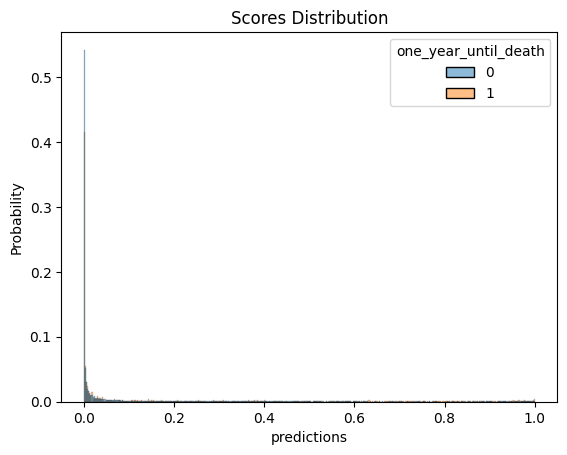

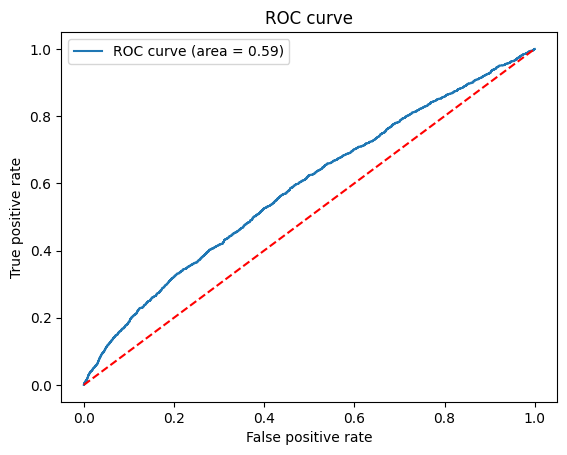

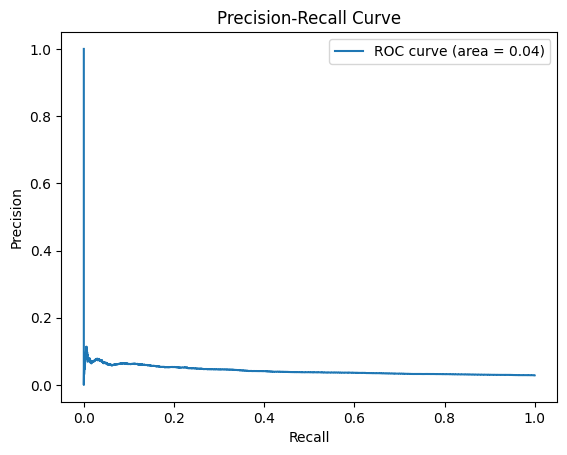

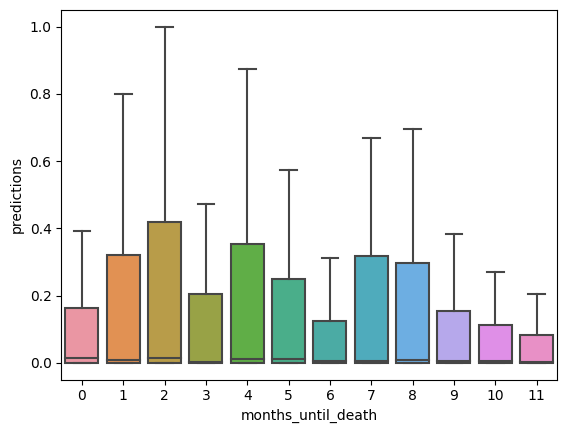

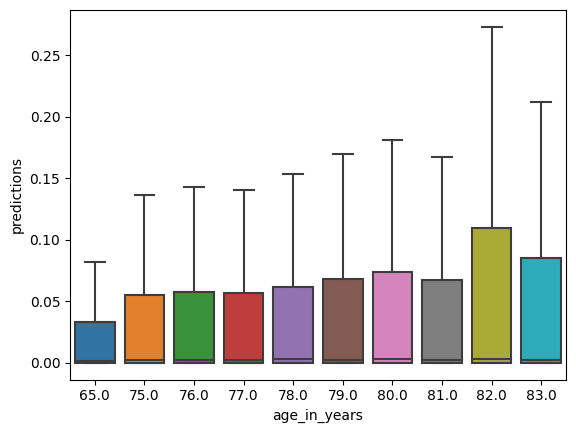

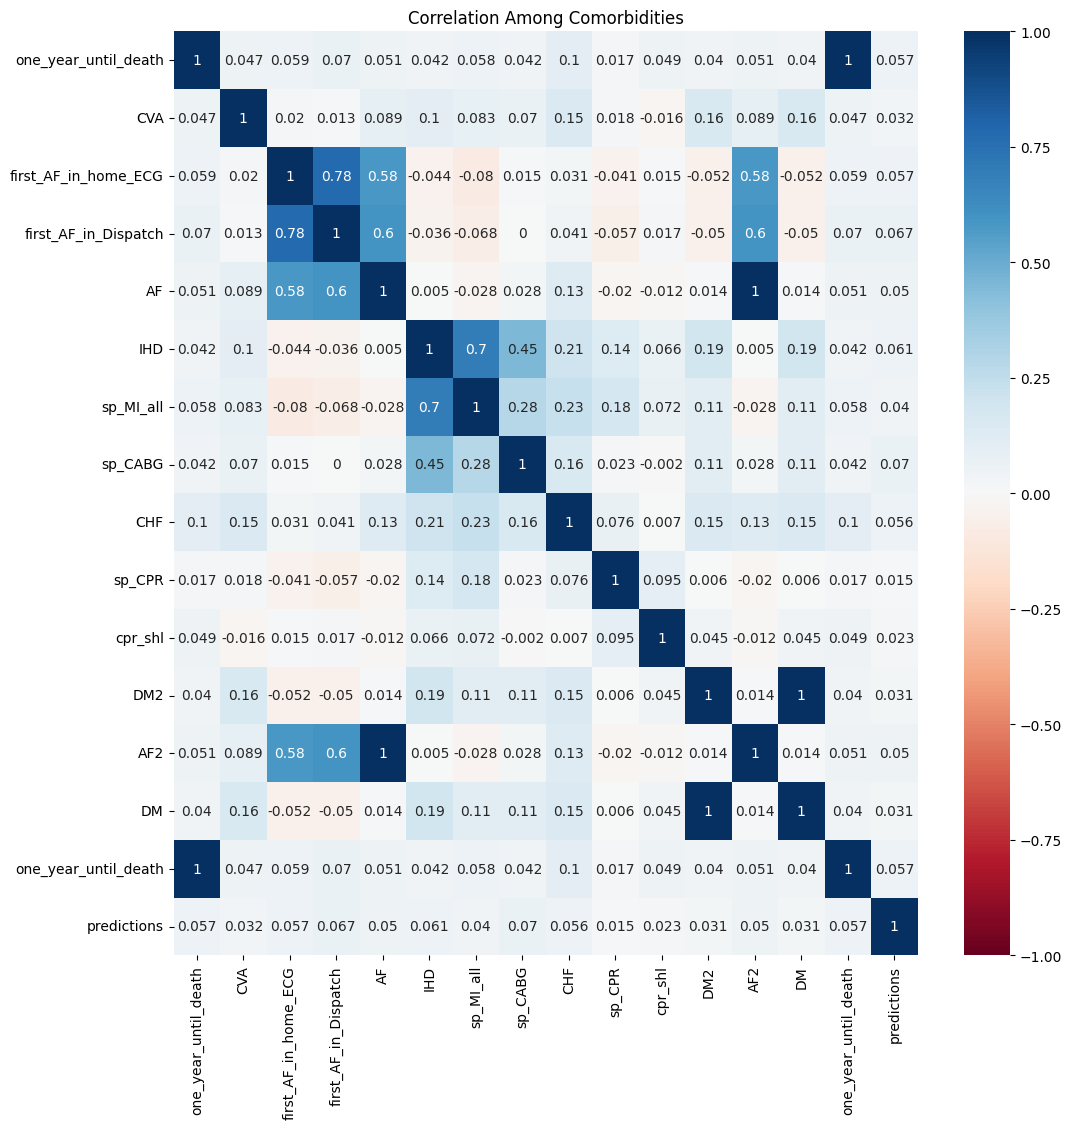

In [120]:
post_reg_analysis(data, 'one_year_until_death', 'predictions')

['sample',
 'reading',
 'dates',
 'one_year_until_death',
 'CVA',
 'first_AF_in_home_ECG',
 'first_AF_in_Dispatch',
 'AF',
 'IHD',
 'sp_MI_all',
 'sp_CABG',
 'CHF',
 'sp_CPR',
 'cpr_shl',
 'DM2',
 'AF2',
 'DM',
 'last_known_date',
 'assumed_dead',
 'approximate_death',
 'test_group',
 'Patient ID',
 'Customer_BirthDate',
 'Age_at_start',
 'dates_datetime',
 'approximate_death_datetime',
 'time_until_approximate_death',
 'days_until_approximate_death',
 'Customer_BirthDate_datetime',
 'Customer_BirthDate_1900',
 'age_days',
 'predictions',
 'months_until_death',
 'age_in_years']

### Add - how many good leads per reading

In [1]:
import os

# make sure we're in the correct directory
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')

# import trainer
from dataloader.DataLoader import *

train_generator = DataGenerator(
    metadata_file_path= './data/combined_data/metadata.csv',   # path to metadata file
    data_folder_path = './data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['AF'],             # list of targets we want train on
    batch_size=4,           # batch size
    shuffle=True       # Whether to shuffle the list of IDs at the end of each epoch.
                 )

X,y = train_generator.__getitem__(1224)
print(X.shape, y.shape)
X,y




(4, 12, 450) (4, 1, 1)


(array([[[0.35402725, 0.35850949, 0.3635456 , ..., 0.39769277,
          0.40853832, 0.43354973],
         [0.22749712, 0.24434748, 0.25342457, ..., 0.15771653,
          0.15373151, 0.15559684],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [0.28215296, 0.30072478, 0.3116115 , ..., 0.51373526,
          0.36663725, 0.16333737],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],
 
        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [0.27478585, 0.26573882, 0.26672554, ..., 0.18485005,
          0.19117195, 0.19700235],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,   

In [3]:
num_nonmissing_leads = [np.count_nonzero(~np.isnan(X[j][:,0])) for j in range(len(X))]

[4, 5, 1, 10]

In [81]:
pd.DataFrame(data['non_missing_leads'].value_counts())

,count
non_missing_leads,
2,14194
1,11418
3,10897
4,9411
5,5068
0,4463


<Axes: xlabel='y_pred', ylabel='Probability'>

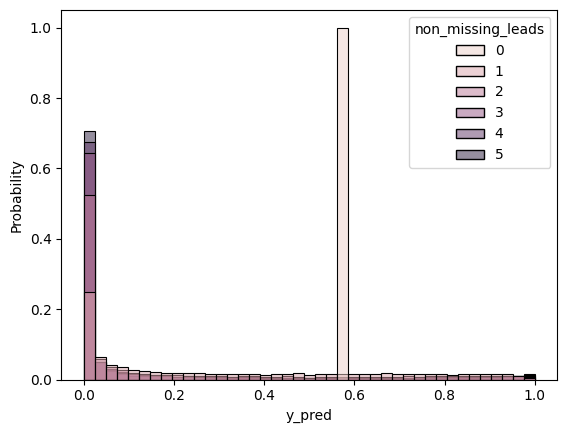

In [48]:
sns.histplot(data = data, x='y_pred', hue = 'non_missing_leads', common_norm=False, stat='probability')

y_pred  one_year_until_death
non_missing_leads                                                     
0                 y_pred                     NaN                   NaN
                  one_year_until_death       NaN              1.000000
1                 y_pred                1.000000              0.113941
                  one_year_until_death  0.113941              1.000000
2                 y_pred                1.000000              0.101282
                  one_year_until_death  0.101282              1.000000
3                 y_pred                1.000000              0.082460
                  one_year_until_death  0.082460              1.000000
4                 y_pred                1.000000              0.065990
                  one_year_until_death  0.065990              1.000000
5                 y_pred                1.000000              0.046266
                  one_year_until_death  0.046266              1.000000

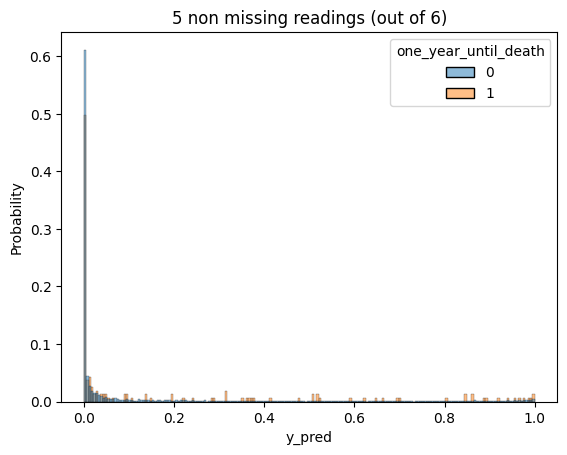

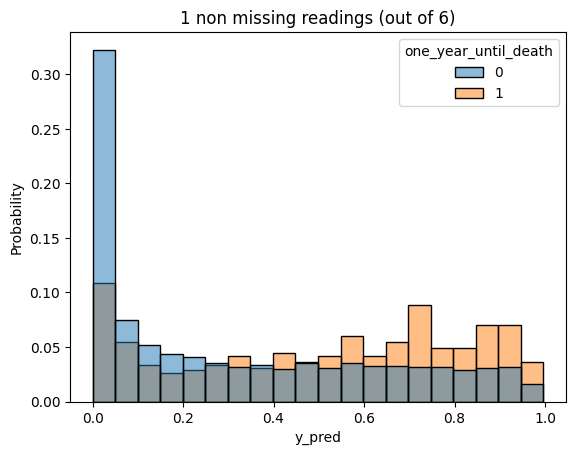

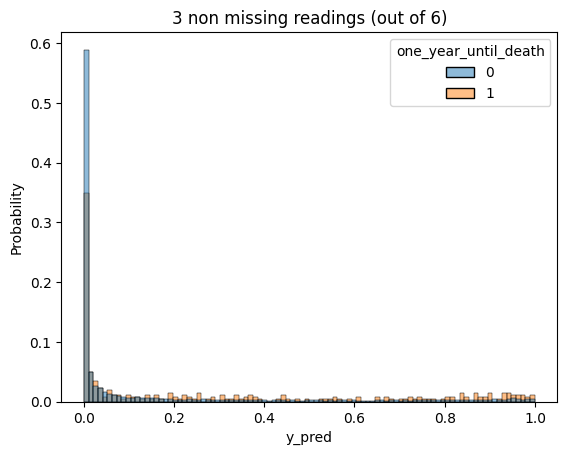

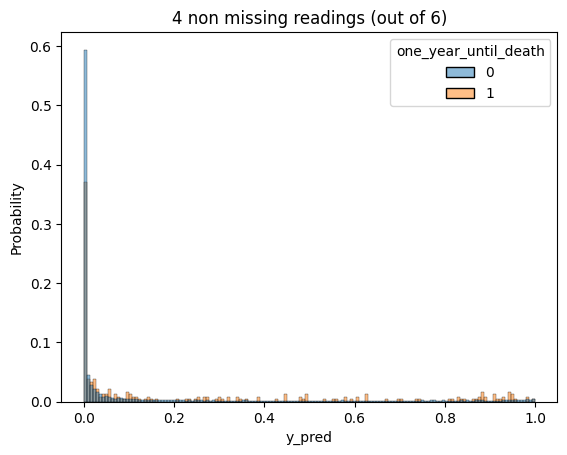

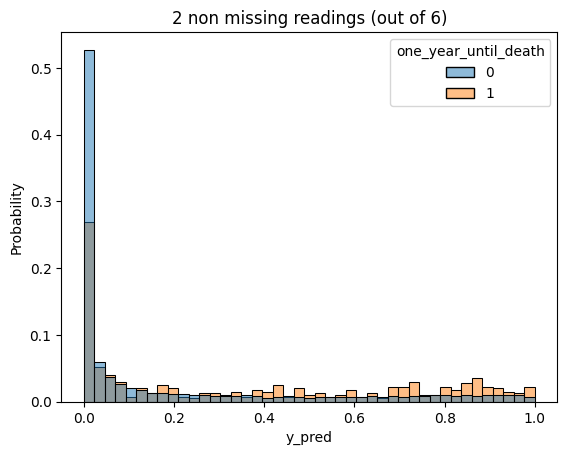

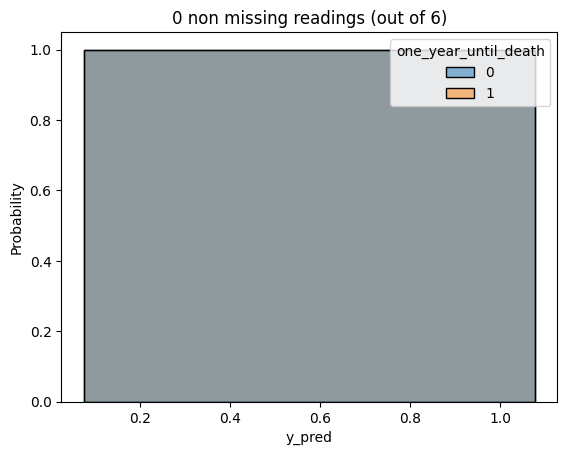

In [67]:
display(data.groupby(['non_missing_leads'])[['y_pred','one_year_until_death']].corr())
categories = data['non_missing_leads'].unique()

for cat in categories:
    mask = data['non_missing_leads']==cat
    sns.histplot(data = data[mask].reset_index(drop=True), x = 'y_pred', hue = 'one_year_until_death', common_norm=False,stat='probability')
    plt.title(f'{cat} non missing readings (out of {len(categories)})')
    plt.show()



In [71]:
pd.crosstab(data['one_year_until_death'],
            data['y_pred']>0.1,
            normalize='index')

y_pred,False,True
one_year_until_death,,
0,0.602563,0.397437
1,0.384760,0.615240


In [73]:
pd.crosstab(data['one_year_until_death'],
            data['y_pred']>0.1)

y_pred,False,True
one_year_until_death,,
0,32448,21402
1,616,985


In [80]:
for j in np.linspace(0,1,10):
    print(f'confussion mat for {np.round(j,4)}:')
    display(
        pd.crosstab(data['one_year_until_death'],
                    (data['y_pred']>j).astype(int),
                    normalize='index')
    )

confussion mat for 0.0:


y_pred,1
one_year_until_death,
0,1.0
1,1.0


confussion mat for 0.1111:


y_pred,0,1
one_year_until_death,,
0,0.610065,0.389935
1,0.391006,0.608994


confussion mat for 0.2222:


y_pred,0,1
one_year_until_death,,
0,0.669991,0.330009
1,0.450968,0.549032


confussion mat for 0.3333:


y_pred,0,1
one_year_until_death,,
0,0.710975,0.289025
1,0.502811,0.497189


confussion mat for 0.4444:


y_pred,0,1
one_year_until_death,,
0,0.745014,0.254986
1,0.561524,0.438476


confussion mat for 0.5556:


y_pred,0,1
one_year_until_death,,
0,0.777159,0.222841
1,0.612742,0.387258


confussion mat for 0.6667:


y_pred,0,1
one_year_until_death,,
0,0.889601,0.110399
1,0.757651,0.242349


confussion mat for 0.7778:


y_pred,0,1
one_year_until_death,,
0,0.923194,0.076806
1,0.831980,0.168020


confussion mat for 0.8889:


y_pred,0,1
one_year_until_death,,
0,0.959443,0.040557
1,0.913804,0.086196


confussion mat for 1.0:


y_pred,0
one_year_until_death,
0,1.0
1,1.0


In [83]:
data[['y_pred', 'one_year_until_death']]

,y_pred,one_year_until_death
0,6.546896e-06,0
1,9.319060e-01,0
2,2.705155e-06,0
3,1.153201e-02,0
4,7.440771e-01,1
...,...,...
55446,1.017480e-04,0
55447,1.874881e-03,0
55448,5.133476e-01,0
55449,2.596552e-07,0


In [91]:
def get_tpr_for_fpr_budget(y_true, y_pred, fpr_budget = 0.6):
    """
    This funciton tells for a budget of false positive rate, what rate of true positives we can get.
    """
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    closest_index = np.argmin(np.abs(fpr - fpr_budget))
    return tpr[closest_index]

In [96]:
get_tpr_for_fpr_budget(data['one_year_until_death'], data['y_pred'], fpr_budget = 0.6)

0.7820112429731418

<Axes: xlabel='y_pred', ylabel='Probability'>

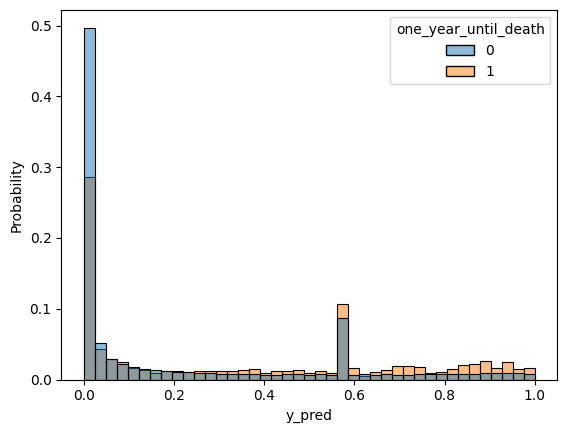

In [100]:
# data['one_year_until_death'], data['y_pred']

sns.histplot(data = data, x = 'y_pred', hue = 'one_year_until_death', common_norm=False, stat='probability')

In [90]:
pd.crosstab()

0.5995728876508821

In [88]:
import numpy as np

# Create an increasing numpy array
array = np.array([0, 0.1, 0.2, 0.4, 0.9, 1])

# Find the index of the element closest to 0.5
closest_index = np.argmin(np.abs(array - 0.5))

# Print the closest index
print(closest_index)

3


# Add Weights to Torch Model

In [122]:
import torch
import torch.nn as nn

# Define the BCEWithLogitsLoss function with weight parameter
# weight = torch.tensor([[0.1], 
#                        [0.2],
#                        [0.7]]) # higher weight for positive class
# loss = torch.nn.CrossEntropyLoss(weight=torch.tensor([5, 1]))
criterion = nn.BCELoss(weight=torch.tensor([5,2]))
# # Generate some random data for the binary classification problem
input = torch.randn(4, 1)
sigmoid = nn.Sigmoid()
input = sigmoid(input)
target = torch.tensor([[0.], 
                       [1.], 
                       [1.],
                       [0.]])
# # Compute the loss with the specified weight
loss = criterion(input, target)
print(loss)


RuntimeError: output with shape [4, 1] doesn't match the broadcast shape [4, 2]

In [121]:
input

tensor([[ 1.0332],
        [ 0.1075],
        [-1.0972],
        [ 0.1050]])

In [131]:
import torch
import torch.nn as nn
import torch.optim as optim

# define the weight for the positive class
pos_weight = torch.tensor([2.0])

# define the BCELoss with weight
criterion = nn.BCELoss()
criterion_weighted = nn.BCELoss(weight=pos_weight)

# define the inputs and labels
inputs = torch.tensor([0.2, 0.8, 0.6, 0.4])
labels = torch.tensor([0., 1., 0., 0.])

# calculate the loss
loss = criterion(inputs, labels)
loss_weighted = criterion_weighted(inputs, labels)
loss,loss_weighted

(tensor(0.4684), tensor(0.9367))

In [133]:
_ = pd.read_csv('./data/combined_data/metadata_only_existant_readings_09042023.csv',index_col=0)
_[_['sample']=='train']['one_year_until_death'].value_counts(normalize=True)

one_year_until_death
0    0.970514
1    0.029486
Name: proportion, dtype: float64

In [134]:
1/0.029486

33.91440005426304